Iñigo Martin Melero

## Participante 6

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_6_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0    4.777     10
1           50      5.0    4.777     10
2          100      5.0    4.777     10
3          150      5.0    4.777     10
4          200      5.0    4.777     10
...        ...      ...      ...    ...
49027  2451350      5.0    5.000     12
49028  2451400      5.0    5.000     12
49029  2451450      5.0    5.000     12
49030  2451500      5.0    5.000     12
49031  2451550      5.0    5.000     12

[49032 rows x 4 columns]


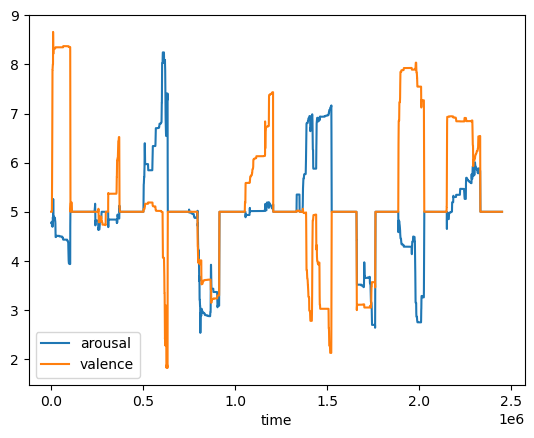

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_6_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.797  35.817  17.785  41.781  31.609    13.820     7.987   
1              1  0.781  35.943  17.824  41.752  31.598    13.615     7.864   
2              2  0.764  36.069  17.864  41.723  31.588    13.409     7.741   
3              3  0.780  36.186  17.864  41.732  31.591    13.448     7.699   
4              4  0.790  36.206  17.841  41.761  31.598    13.570     7.861   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.945  35.643   8.330  40.745  27.212    40.180     7.658   
2451580  2451580  0.941  35.376   8.331  40.736  27.205    40.509     7.576   
2451581  2451581  0.951  35.507   8.405  40.774  27.216    40.797     7.698   
2451582  2451582  0.945  35.605   8.429  40.765  27.205    40.881     7.699   
2451583  2451583  0.948  35.797   8.351  40.822  27.226    40.760     7.740   

         emg_trap  video  
0           9.014     10

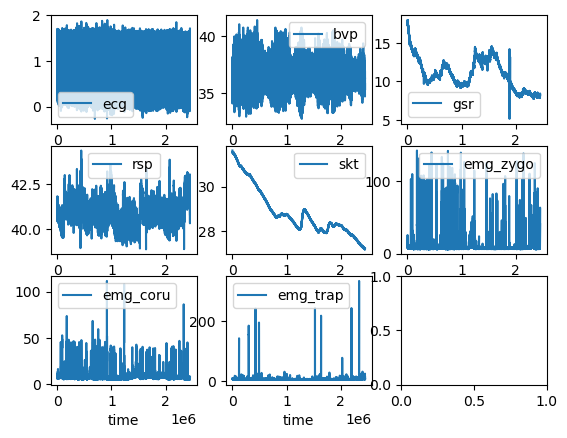

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

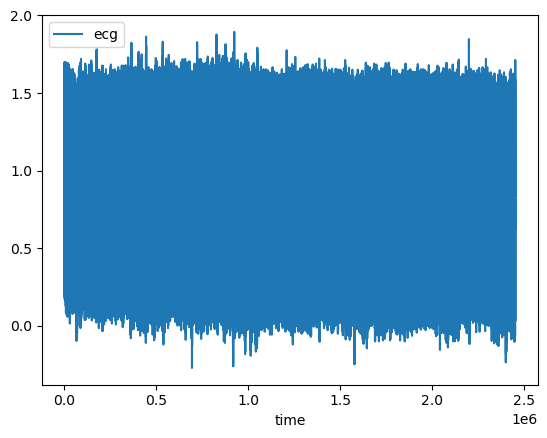

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

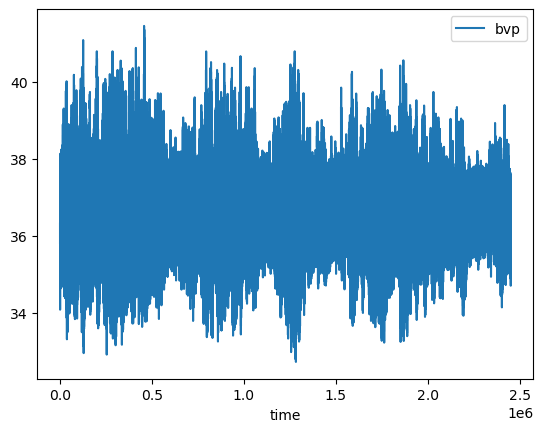

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

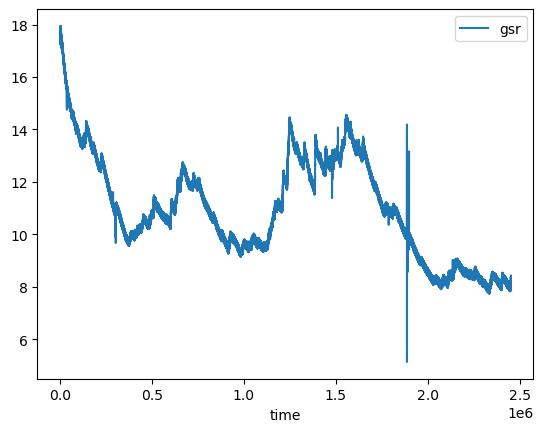

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

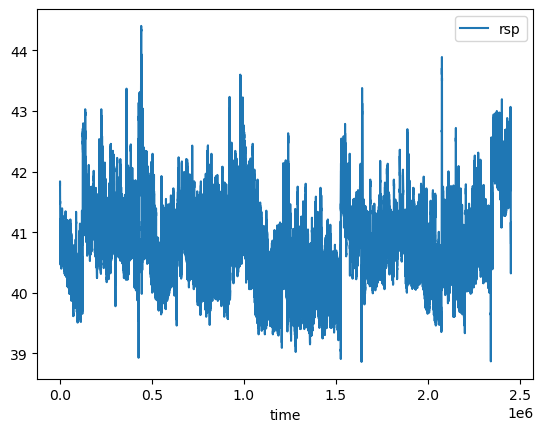

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

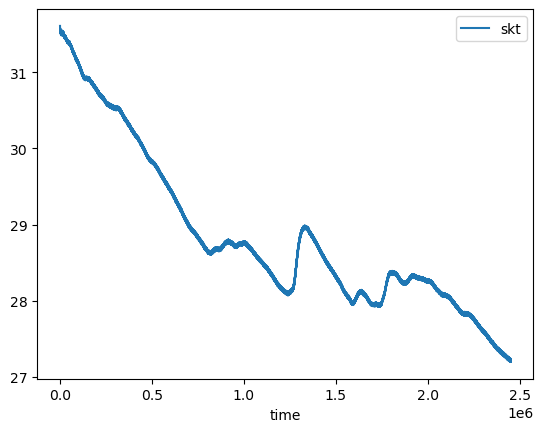

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

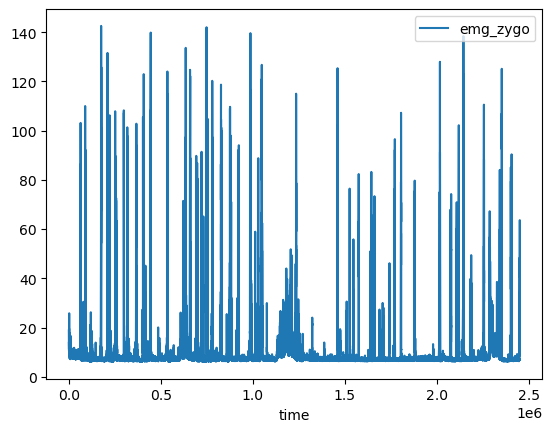

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

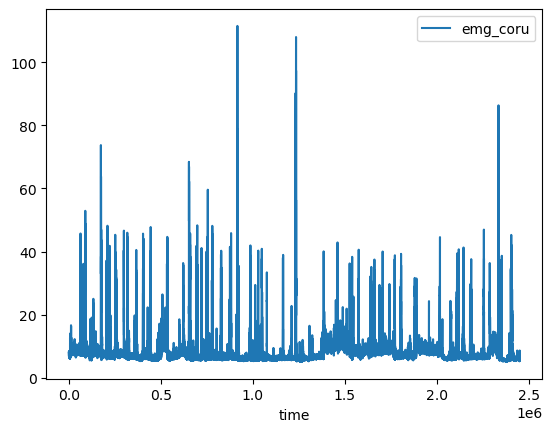

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

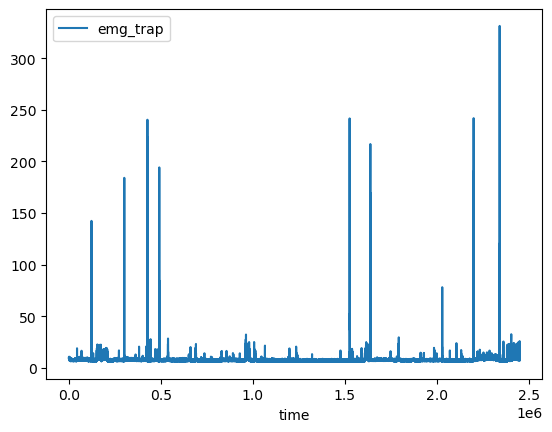

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

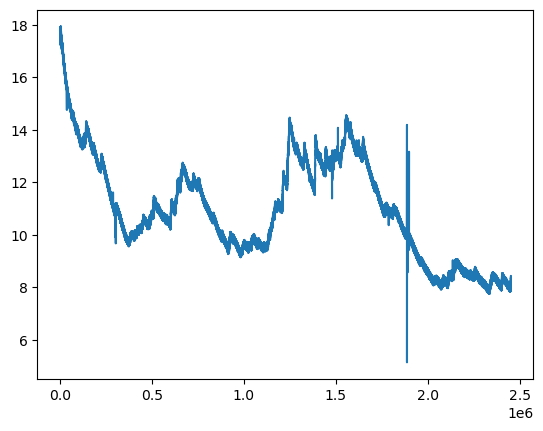

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

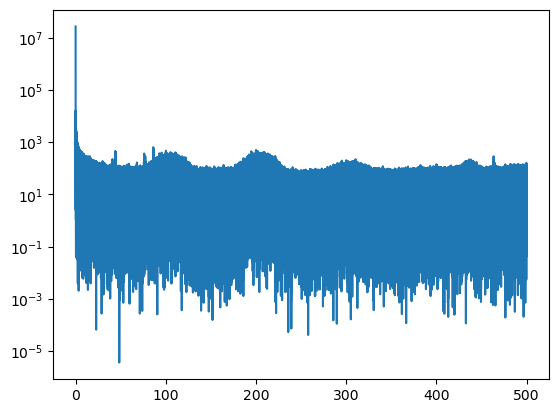

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

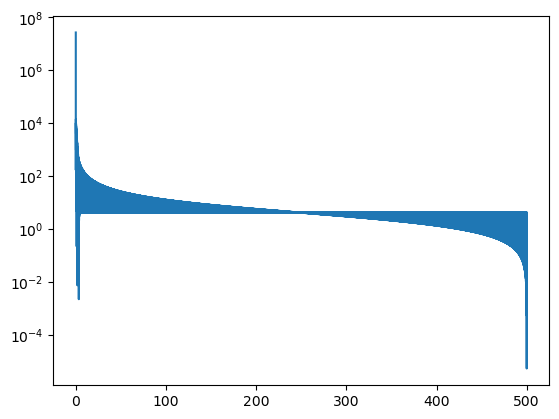

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

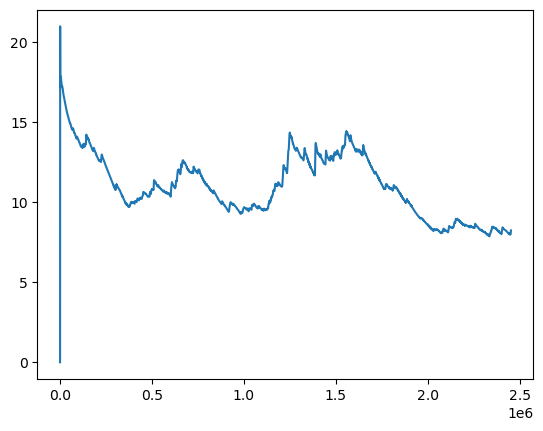

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
...        ...
2451579  8.240
2451580  8.241
2451581  8.241
2451582  8.241
2451583  8.241

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

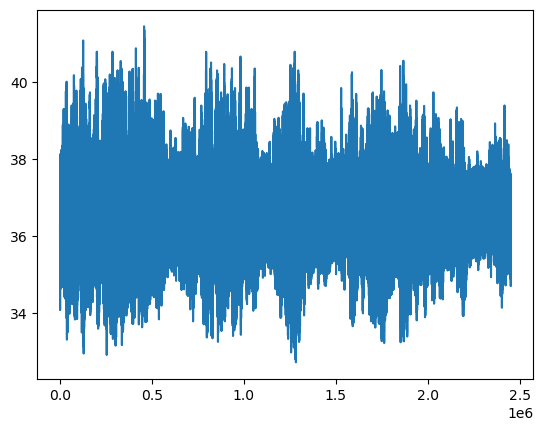

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

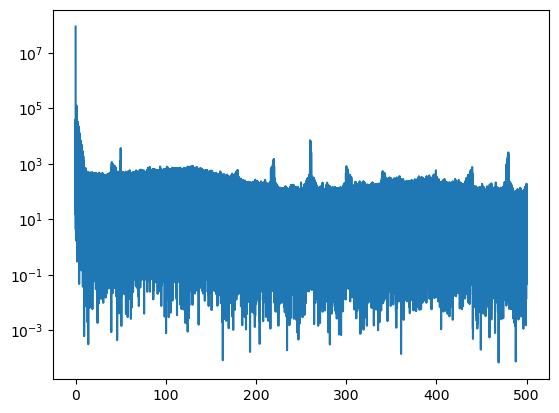

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

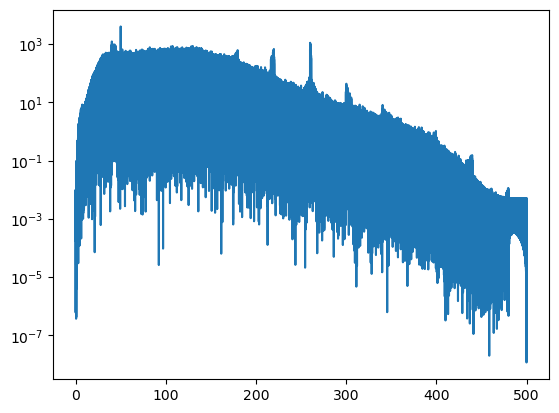

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

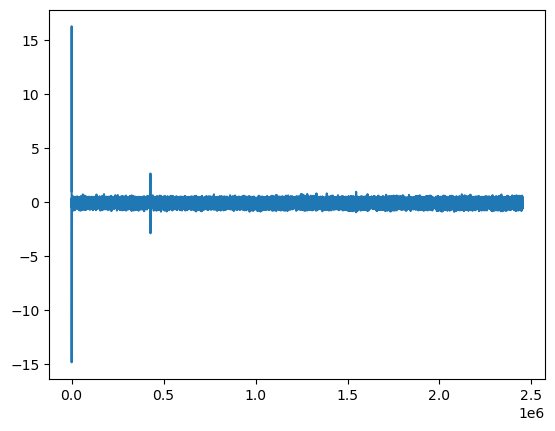

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.995
1        42.556
2        50.086
3        53.221
4        46.156
...         ...
2451579  36.916
2451580  36.965
2451581  37.046
2451582  37.059
2451583  37.025

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

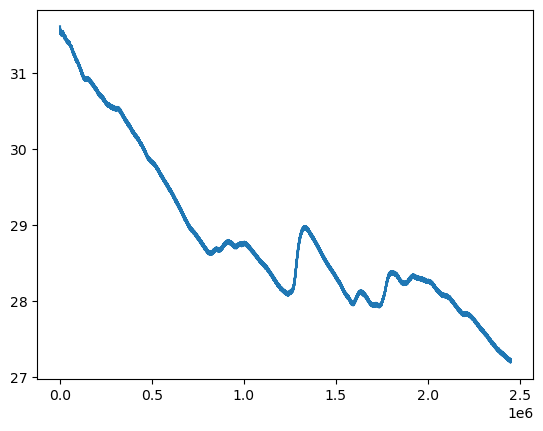

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

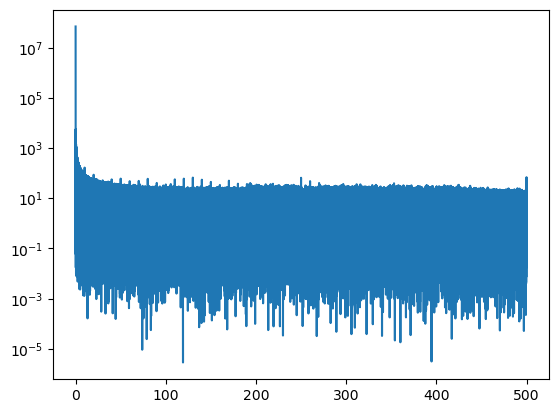

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

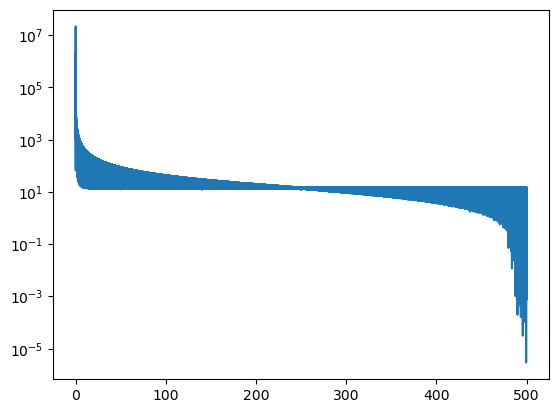

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

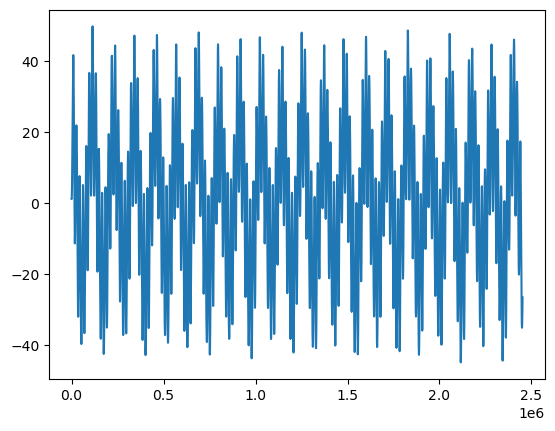

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        41.013
1        41.013
2        41.012
3        41.012
4        41.013
...         ...
2451579  13.261
2451580  13.266
2451581  13.272
2451582  13.276
2451583  13.282

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.797  41.781    13.820     7.987     9.014     10
1              1  0.781  41.752    13.615     7.864     8.972     10
2              2  0.764  41.723    13.409     7.741     8.931     10
3              3  0.780  41.732    13.448     7.699     8.931     10
4              4  0.790  41.761    13.570     7.861     8.972     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.945  40.745    40.180     7.658     7.946     12
2451580  2451580  0.941  40.736    40.509     7.576     7.905     12
2451581  2451581  0.951  40.774    40.797     7.698     7.985     12
2451582  2451582  0.945  40.765    40.881     7.699     7.946     12
2451583  2451583  0.948  40.822    40.760     7.740     7.986     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.797  41.781    13.820     7.987     9.014     10  37.995   
1              1  0.781  41.752    13.615     7.864     8.972     10  42.556   
2              2  0.764  41.723    13.409     7.741     8.931     10  50.086   
3              3  0.780  41.732    13.448     7.699     8.931     10  53.221   
4              4  0.790  41.761    13.570     7.861     8.972     10  46.156   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.945  40.745    40.180     7.658     7.946     12  36.916   
2451580  2451580  0.941  40.736    40.509     7.576     7.905     12  36.965   
2451581  2451581  0.951  40.774    40.797     7.698     7.985     12  37.046   
2451582  2451582  0.945  40.765    40.881     7.699     7.946     12  37.059   
2451583  2451583  0.948  40.822    40.760     7.740     7.986     12  37.025   

           gsr     skt  
0        0.000  41.013  
1        0.000  41.013  
2        0.000  41.012  
3        0.000  41.012  
4        0.000  41.013  
...        ...     ...  
2451579  8.240  13.261  
2451580  8.241  13.266  
2451581  8.241  13.272  
2451582  8.241  13.276  
2451583  8.241  13.282  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.453744  0.573547  0.796921  0.792972  0.338771  0.729894   
221502    221502  0.447381  0.537367  0.796748  0.792894  0.336407  0.720787   
221503    221503  0.464513  0.501186  0.796748  0.792816  0.345390  0.715692   
221504    221504  0.458639  0.525504  0.796748  0.792739  0.336407  0.704297   
221505    221505  0.467939  0.574733  0.796748  0.792661  0.334043  0.691178   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.424376  0.528470  0.000173  0.361602  0.322695  0.126000   
2331580  2331580  0.427802  0.508304  0.000000  0.361691  0.322695  0.125680   
2331581  2331581  0.424865  0.543891  0.000000  0.361768  0.322695  0.125672   
2331582  2331582  0.430739  0.617438  0.000000  0.361857  0.331678  0.125344   
2331583  2331583  0.418502  0.644721  0.000000  0.361935  0.318203  0.122669   

         emg_coru  emg_trap  video  
221501   0.354539  0.003483      6  
221502   0.353785  0.003653      6  
221503   0.353785  0.004343      6  
221504   0.352275  0.004004      6  
221505   0.352257  0.004173      6  
...           ...       ...    ...  
2331579  0.047585  0.018251      1  
2331580  0.049094  0.017739      1  
2331581  0.050604  0.017388      1  
2331582  0.052868  0.017557      1  
2331583  0.050641  0.016871      1  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0    4.777
1            5.0    4.774
2            5.0    4.771
3            5.0    4.768
4            5.0    4.766
...          ...      ...
2451579      5.0    4.794
2451580      5.0    4.791
2451581      5.0    4.787
2451582      5.0    4.783
2451583      5.0    4.780

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.453744  0.573547  0.796921  0.338771  0.792972  0.729894   
221502    221502  0.447381  0.537367  0.796748  0.336407  0.792894  0.720787   
221503    221503  0.464513  0.501186  0.796748  0.345390  0.792816  0.715692   
221504    221504  0.458639  0.525504  0.796748  0.336407  0.792739  0.704297   
221505    221505  0.467939  0.574733  0.796748  0.334043  0.792661  0.691178   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.424376  0.528470  0.000173  0.322695  0.361602  0.126000   
2331580  2331580  0.427802  0.508304  0.000000  0.322695  0.361691  0.125680   
2331581  2331581  0.424865  0.543891  0.000000  0.322695  0.361768  0.125672   
2331582  2331582  0.430739  0.617438  0.000000  0.331678  0.361857  0.125344   
2331583  2331583  0.418502  0.644721  0.000000  0.318203  0.361935  0.122669   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
221540   0.456681  0.600830  0.796575  0.331915  0.789971  0.820263  0.430049   
221560   0.460108  0.534401  0.796402  0.329551  0.788427  0.523977  0.433344   
221580   0.455213  0.537960  0.796229  0.334043  0.786893  0.473849  0.387821   
221600   0.453744  0.504745  0.796229  0.329551  0.785348  0.495918  0.394577   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.439060  0.529063  0.000346  0.306619  0.355012  0.098056  0.039264   
2331520  0.435634  0.548043  0.000346  0.306619  0.356690  0.096022  0.043793   
2331540  0.418013  0.519573  0.000346  0.313475  0.358357  0.089975  0.046812   
2331560  0.429271  0.526690  0.000173  0.315839  0.360024  0.074100  0.038528   
2331580  0.427802  0.508304  0.000000  0.322695  0.361691  0.125680  0.049094   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1      0.456681  0.600830  0.796575  0.331915  0.789971  0.820263  0.430049   
2      0.460108  0.534401  0.796402  0.329551  0.788427  0.523977  0.433344   
3      0.455213  0.537960  0.796229  0.334043  0.786893  0.473849  0.387821   
4      0.453744  0.504745  0.796229  0.329551  0.785348  0.495918  0.394577   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.439060  0.529063  0.000346  0.306619  0.355012  0.098056  0.039264   
63500  0.435634  0.548043  0.000346  0.306619  0.356690  0.096022  0.043793   
63501  0.418013  0.519573  0.000346  0.313475  0.358357  0.089975  0.046812   
63502  0.429271  0.526690  0.000173  0.315839  0.360024  0.074100  0.038528   
63503  0.427802  0.508304  0.000000  0.322695  0.361691  0.125680  0.049094   

       emg_trap  valence  arousal  
0      0.003831    5.000    5.000  
1      0.004351    5.000    5.000  
2      0.003657    5.000    5.000  
3      0.004690    5.000    5.000  
4      0.004347    5.000    5.000  
...         ...      ...      ...  
63499  0.017379    6.538    5.845  
63500  0.019805    6.538    5.845  
63501  0.018598    6.538    5.845  
63502  0.020863    6.538    5.844  
63503  0.017739    6.538    5.842  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1      0.456681  0.600830  0.796575  0.331915  0.789971  0.820263  0.430049   
2      0.460108  0.534401  0.796402  0.329551  0.788427  0.523977  0.433344   
3      0.455213  0.537960  0.796229  0.334043  0.786893  0.473849  0.387821   
4      0.453744  0.504745  0.796229  0.329551  0.785348  0.495918  0.394577   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.460108  0.568802  0.000346  0.290544  0.348321  0.123629  0.036982   
63496  0.451787  0.536773  0.000519  0.292908  0.349999  0.089623  0.047566   
63497  0.458150  0.539146  0.000519  0.299764  0.351666  0.095956  0.041547   
63498  0.447381  0.540332  0.000519  0.301891  0.353345  0.080877  0.036245   
63499  0.439060  0.529063  0.000346  0.306619  0.355012  0.098056  0.039264   

       emg_trap  valence  arousal  
0      0.003831    5.000    5.000  
1      0.004351    5.000    5.000  
2      0.003657    5.000    5.000  
3      0.004690    5.000    5.000  
4      0.004347    5.000    5.000  
...         ...      ...      ...  
63495  0.013557    6.537    5.845  
63496  0.012516    6.537    5.845  
63497  0.011991    6.538    5.845  
63498  0.015813    6.538    5.845  
63499  0.017379    6.538    5.845  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
 1   0.456681  0.600830  0.796575  0.331915  0.789971  0.820263  0.430049   
 2   0.460108  0.534401  0.796402  0.329551  0.788427  0.523977  0.433344   
 3   0.455213  0.537960  0.796229  0.334043  0.786893  0.473849  0.387821   
 4   0.453744  0.504745  0.796229  0.329551  0.785348  0.495918  0.394577   
 5   0.460108  0.591934  0.796056  0.331915  0.783804  0.468910  0.483083   
 6   0.453744  0.565836  0.795883  0.327423  0.782248  0.514033  0.394614   
 7   0.498776  0.525504  0.795710  0.329551  0.780703  0.471445  0.379538   
 8   0.505140  0.545077  0.795710  0.329551  0.779147  0.427914  0.331916   
 9   0.508076  0.432977  0.795537  0.331678  0.777591  0.524928  0.445181   
 10  0.479197  0.569395  0.795537  0.308983  0.776035  0.486935  0.633624   
 11  0.432697  0.518980  0.795364  0.306619  0.774469  0.519284  0.323651   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1     0.640235  0.518387  0.795018  0.304255  0.752520  0.422319  0.259351   
2     0.501713  0.555160  0.798651  0.288180  0.713301  0.050193  0.033981   
3     0.440529  0.556940  0.810067  0.317967  0.675172  0.008073  0.037737   
4     0.415076  0.530249  0.824771  0.590307  0.639265  0.003700  0.024151   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.487518  0.542112  0.005881  0.512530  0.169654  0.059981  0.034754   
2536  0.421439  0.567023  0.004670  0.423168  0.199838  0.061630  0.037000   
2537  0.488987  0.561091  0.002422  0.336407  0.234855  0.125007  0.043056   
2538  0.435634  0.538553  0.001730  0.279196  0.273618  0.111413  0.044566   
2539  0.490455  0.564057  0.000692  0.238061  0.314759  0.043482  0.032509   

             8         9        10  ...       193       194       195  \
0     0.003831  0.456681  0.600830  ...  0.609398  0.511269  0.795018   
1     0.006781  0.688204  0.565836  ...  0.495350  0.529656  0.798305   
2     0.002785  0.508076  0.567023  ...  0.442487  0.571174  0.809549   
3     0.004863  0.448850  0.565243  ...  0.126774  0.550415  0.824079   
4     0.009735  0.466471  0.590154  ...  0.411650  0.569988  0.837744   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.014256  0.510034  0.500593  ...  0.434165  0.545670  0.004843   
2536  0.015644  0.421439  0.574733  ...  0.477729  0.564057  0.002595   
2537  0.019119  0.508076  0.590747  ...  0.426334  0.515421  0.001730   
2538  0.010772  0.424865  0.585409  ...  0.398434  0.485172  0.000865   
2539  0.016863  0.517866  0.545077  ...  0.439060  0.529063  0.000346   

           196       197       198       199       200  valence  arousal  
0     0.299764  0.754087  0.502662  0.286485  0.007648    5.000  5.00000  
1     0.288180  0.714857  0.033022  0.039264  0.002959    5.000  5.00000  
2     0.311111  0.676661  0.008098  0.027962  0.004525    5.000  5.00000  
3     0.572104  0.640654  0.003708  0.027170  0.008343    5.000  5.00000  
4     0.814657  0.607748  0.006391  0.024170  0.004521    5.000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.427896  0.198526  0.052220  0.037755  0.013731    6.535  5.88500  
2536  0.340898  0.233377  0.089942  0.037037  0.013384    6.535  5.88268  
2537  0.279196  0.272018  0.119962  0.040038  0.013735    6.535  5.86960  
2538  0.240189  0.313092  0.061654  0.033227  0.015301    6.535  5.86192  
2539  0.306619  0.355012  0.098056  0.039264  0.017379    6.536  5.84500  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1     0.640235  0.518387  0.795018  0.304255  0.752520  0.422319  0.259351   
2     0.501713  0.555160  0.798651  0.288180  0.713301  0.050193  0.033981   
3     0.440529  0.556940  0.810067  0.317967  0.675172  0.008073  0.037737   
4     0.415076  0.530249  0.824771  0.590307  0.639265  0.003700  0.024151   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.487518  0.542112  0.005881  0.512530  0.169654  0.059981  0.034754   
2536  0.421439  0.567023  0.004670  0.423168  0.199838  0.061630  0.037000   
2537  0.488987  0.561091  0.002422  0.336407  0.234855  0.125007  0.043056   
2538  0.435634  0.538553  0.001730  0.279196  0.273618  0.111413  0.044566   
2539  0.490455  0.564057  0.000692  0.238061  0.314759  0.043482  0.032509   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub6.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1     0.640235  0.518387  0.795018  0.304255  0.752520  0.422319  0.259351   
2     0.501713  0.555160  0.798651  0.288180  0.713301  0.050193  0.033981   
3     0.440529  0.556940  0.810067  0.317967  0.675172  0.008073  0.037737   
4     0.415076  0.530249  0.824771  0.590307  0.639265  0.003700  0.024151   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.487518  0.542112  0.005881  0.512530  0.169654  0.059981  0.034754   
2536  0.421439  0.567023  0.004670  0.423168  0.199838  0.061630  0.037000   
2537  0.488987  0.561091  0.002422  0.336407  0.234855  0.125007  0.043056   
2538  0.435634  0.538553  0.001730  0.279196  0.273618  0.111413  0.044566   
2539  0.490455  0.564057  0.000692  0.238061  0.314759  0.043482  0.032509   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub6.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1     0.640235  0.518387  0.795018  0.304255  0.752520  0.422319  0.259351   
2     0.501713  0.555160  0.798651  0.288180  0.713301  0.050193  0.033981   
3     0.440529  0.556940  0.810067  0.317967  0.675172  0.008073  0.037737   
4     0.415076  0.530249  0.824771  0.590307  0.639265  0.003700  0.024151   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.487518  0.542112  0.005881  0.512530  0.169654  0.059981  0.034754   
2536  0.421439  0.567023  0.004670  0.423168  0.199838  0.061630  0.037000   
2537  0.488987  0.561091  0.002422  0.336407  0.234855  0.125007  0.043056   
2538  0.435634  0.538553  0.001730  0.279196  0.273618  0.111413  0.044566   
2539  0.490455  0.564057  0.000692  0.238061  0.314759  0.043482  0.032509   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub6.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1     0.640235  0.518387  0.795018  0.304255  0.752520  0.422319  0.259351   
2     0.501713  0.555160  0.798651  0.288180  0.713301  0.050193  0.033981   
3     0.440529  0.556940  0.810067  0.317967  0.675172  0.008073  0.037737   
4     0.415076  0.530249  0.824771  0.590307  0.639265  0.003700  0.024151   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.487518  0.542112  0.005881  0.512530  0.169654  0.059981  0.034754   
2536  0.421439  0.567023  0.004670  0.423168  0.199838  0.061630  0.037000   
2537  0.488987  0.561091  0.002422  0.336407  0.234855  0.125007  0.043056   
2538  0.435634  0.538553  0.001730  0.279196  0.273618  0.111413  0.044566   
2539  0.490455  0.564057  0.000692  0.238061  0.314759  0.043482  0.032509   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub6.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.451787  0.571767  0.796748  0.327187  0.791505  0.625282  0.381747   
1     0.640235  0.518387  0.795018  0.304255  0.752520  0.422319  0.259351   
2     0.501713  0.555160  0.798651  0.288180  0.713301  0.050193  0.033981   
3     0.440529  0.556940  0.810067  0.317967  0.675172  0.008073  0.037737   
4     0.415076  0.530249  0.824771  0.590307  0.639265  0.003700  0.024151   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.487518  0.542112  0.005881  0.512530  0.169654  0.059981  0.034754   
2536  0.421439  0.567023  0.004670  0.423168  0.199838  0.061630  0.037000   
2537  0.488987  0.561091  0.002422  0.336407  0.234855  0.125007  0.043056   
2538  0.435634  0.538553  0.001730  0.279196  0.273618  0.111413  0.044566   
2539  0.490455  0.564057  0.000692  0.238061  0.314759  0.043482  0.032509   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub6.csv', index=False)